In [1]:
from helpers.benchmark import load_records_from_directory
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba



LOG_DIR = "data/stage_a"
df = load_records_from_directory(LOG_DIR)
print("loaded records:", len(df))

# billed_alibaba_df = load_all_billed_alibaba(f"{LOG_DIR}/alibaba")
# df = inject_billed_alibaba(df, billed_alibaba_df)

# billed_azure_df = load_all_billed_azure(f"{LOG_DIR}/azure")
# df = inject_billed_azure(df, billed_azure_df)

# billed_gcp_df = load_all_billed_gcp(f"{LOG_DIR}/gcp")
# df = inject_billed_gcp(df, billed_gcp_df)

# billed_aws_df = load_all_billed_aws(f"{LOG_DIR}/aws")
# df = inject_billed_aws(df, billed_aws_df)



loaded records: 324863


/tmp/ipykernel_20379/461756091.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: ../holy/plots/StageA/aws_512MB_gemm_regional_lollipop.pdf


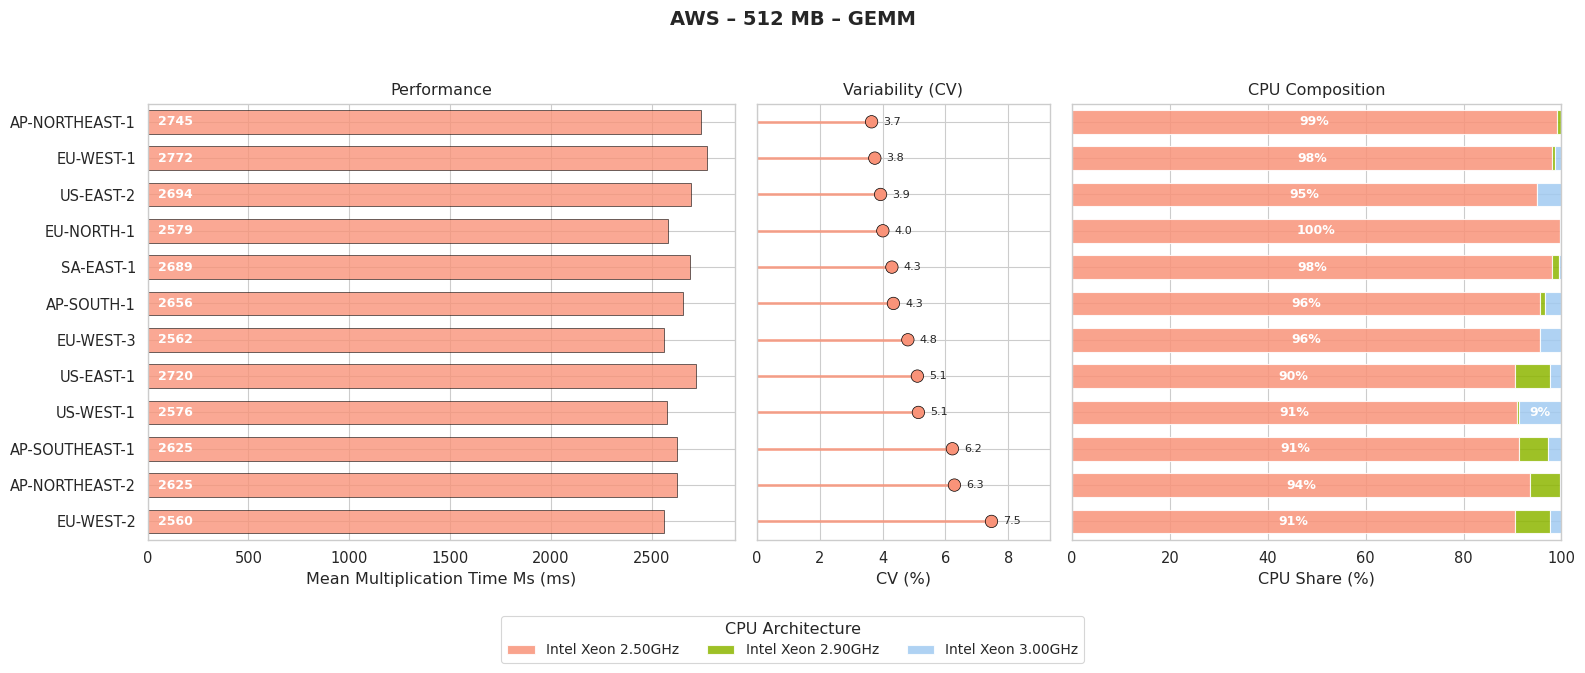

/tmp/ipykernel_20379/461756091.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: ../holy/plots/StageA/alibaba_512MB_gemm_regional_lollipop.pdf


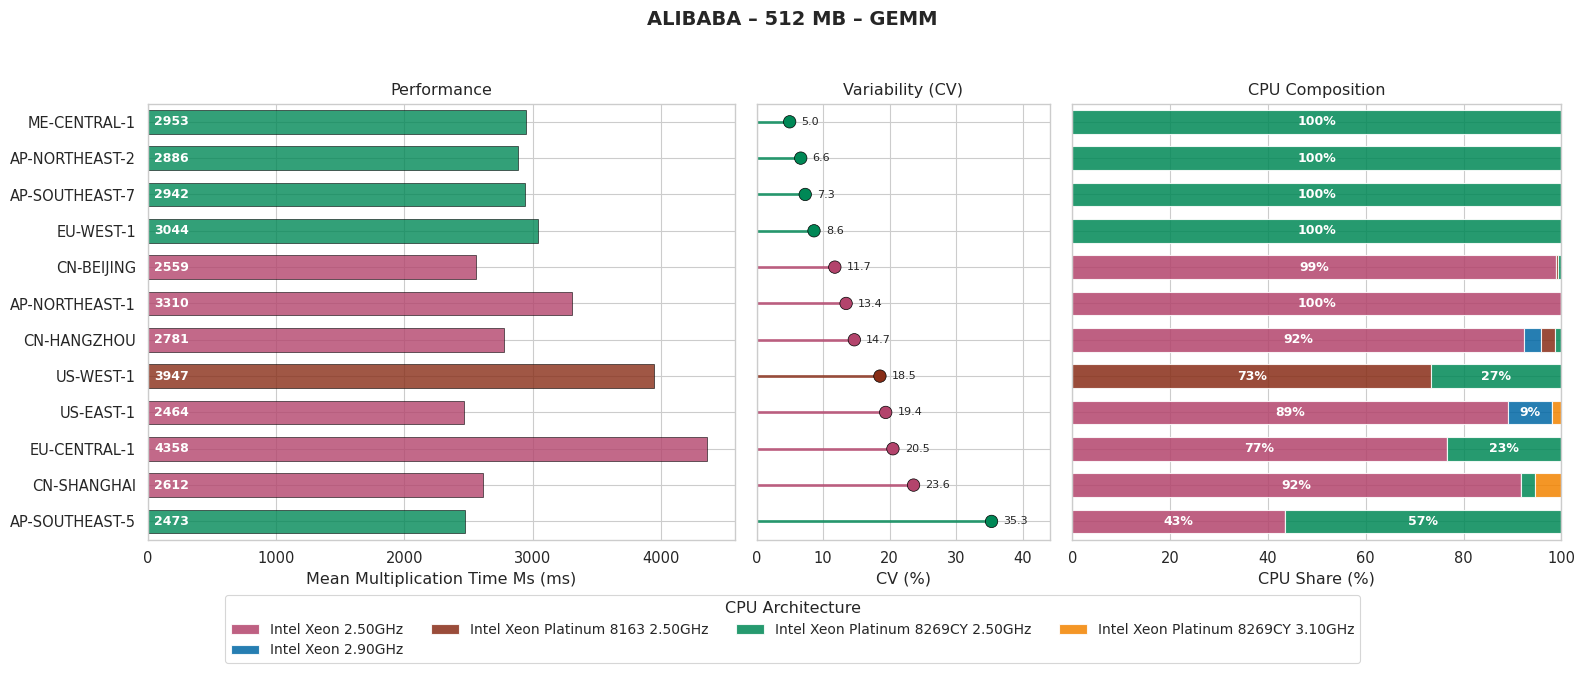

/tmp/ipykernel_20379/461756091.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: ../holy/plots/StageA/gcp_512MB_gemm_regional_lollipop.pdf


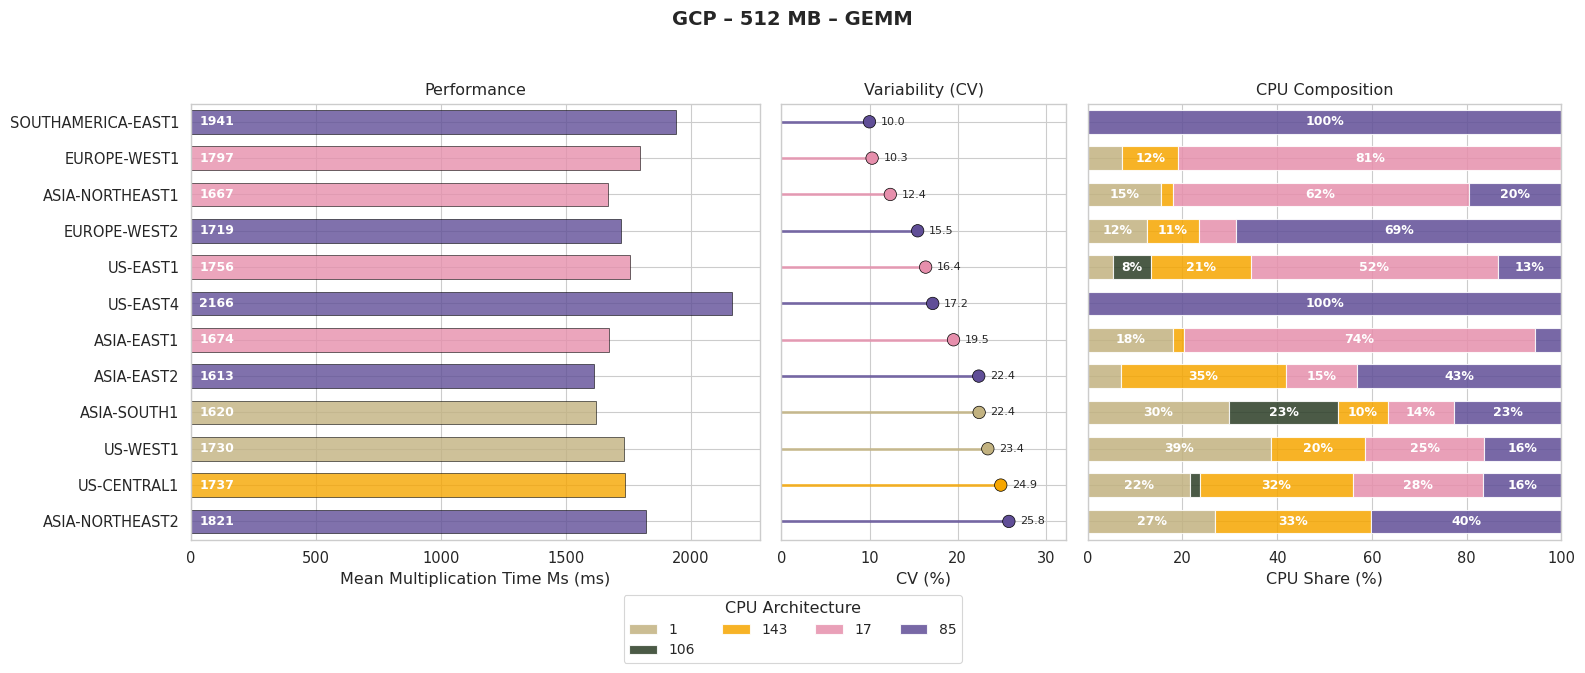

/tmp/ipykernel_20379/461756091.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_stats = df_inst.groupby("region").apply(compute_stats)


Saved: ../holy/plots/StageA/azure_512MB_gemm_regional_lollipop.pdf


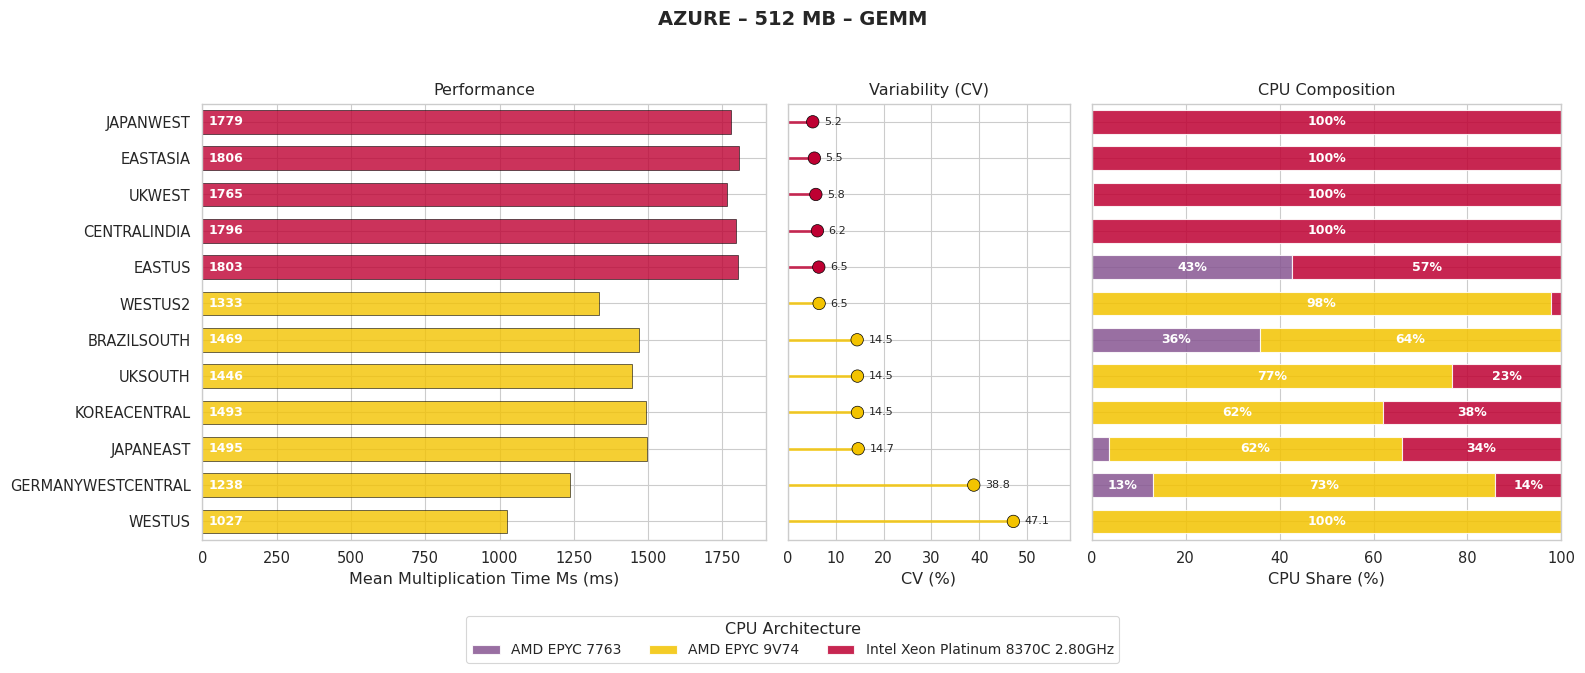

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from helpers.benchmark import filter_cpu_data, metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def create_regional_performance_lollipop(
    df: pd.DataFrame,
    provider: str = "aws",
    memory_size: int = 512,
    benchmark_type: str = "gemm",
    variability_metric: str = "cv",  # "sd" or "cv" (coefficient of variation)
    sort_by: str = "mean",
):
    """
    Create a three-panel figure:
      Left:   Horizontal bars showing mean performance
      Middle: Lollipop chart showing variability (SD or CV)
      Right:  Stacked bar chart of CPU composition by region
    
    Bars are colored by the dominant CPU type in each region.
    """
    
    # 1) Determine regions from raw subset
    df_base = df[
        (df["provider"] == provider)
        & (df["memory_size_mb"] == memory_size)
        & (df["benchmark_type"] == benchmark_type)
    ].copy()

    if df_base.empty:
        print(f"No data found for {provider} {memory_size}MB {benchmark_type}")
        return df_base

    regions = sorted(df_base["region"].dropna().unique().tolist())
    if not regions:
        print(f"No regions found for {provider} {memory_size}MB {benchmark_type}")
        return df_base

    # 2) Filter per region (Tukey outlier removal applied per region)
    filtered_parts = []
    for r in regions:
        part = filter_cpu_data(
            df=df,
            provider=provider,
            memory_size=memory_size,
            benchmark=benchmark_type,
            group_on_timestamp=False,
            region=r,
            remove_cold=True
        )
        if not part.empty:
            filtered_parts.append(part)

    if not filtered_parts:
        print(f"No data left after regional filtering for {provider} {memory_size}MB {benchmark_type}")
        return df_base.iloc[0:0]

    df_filtered = pd.concat(filtered_parts, ignore_index=True)

    # Metric setup
    metric = metric_for_benchmark(benchmark_type)
    metric_label = metric.replace("_", " ").title()

    regions = sorted(df_filtered["region"].unique())
    n_regions = len(regions)

    # CPU palette
    all_cpu_types = sorted(df_filtered["cpu_type"].unique())
    cpu_colors = get_cpu_palette(all_cpu_types, provider=provider)

    # 3) Compute per-instance warm means
    df_inst = (
        df_filtered
        .groupby(["region", "instance_id", "cpu_type"], as_index=False)[metric]
        .mean()
        .rename(columns={metric: "inst_warm_mean"})
    )

    # 4) CPU composition + dominant CPU per region
    cpu_dist_data = []
    region_dominant_cpu = {}

    for r in regions:
        df_region = df_filtered[df_filtered["region"] == r]
        cpu_counts = df_region["cpu_type"].value_counts()
        total = len(df_region)

        region_dist = {"region": r}
        for cpu_type in all_cpu_types:
            region_dist[cpu_type] = (cpu_counts.get(cpu_type, 0) / total * 100) if total else 0.0

        cpu_dist_data.append(region_dist)
        region_dominant_cpu[r] = cpu_counts.idxmax() if not cpu_counts.empty else (all_cpu_types[0] if all_cpu_types else "Unknown")

    cpu_dist_df = pd.DataFrame(cpu_dist_data).set_index("region")

    # 5) Compute statistics per region
    def compute_stats(group):
        values = group["inst_warm_mean"]
        mean = values.mean()
        std = values.std()
        cv = (std / mean * 100) if mean > 0 else 0  # CV as percentage
        
        return pd.Series({
            "mean": mean,
            "std": std,
            "cv": cv,
            "count": len(values)
        })
    
    regional_stats = df_inst.groupby("region").apply(compute_stats)

    # Sort regions
    if sort_by == "cv":
        regions_sorted = regional_stats.sort_values("cv", ascending=False).index.tolist()
    elif sort_by == "std":
        regions_sorted = regional_stats.sort_values("std", ascending=False).index.tolist()
    else:
        regions_sorted = regional_stats.sort_values("mean", ascending=True).index.tolist()

    regional_stats = regional_stats.reindex(regions_sorted)
    cpu_dist_df = cpu_dist_df.reindex(regions_sorted)

    # 6) Create figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3,
        figsize=(16, max(6, n_regions * 0.55)),
        gridspec_kw={"width_ratios": [1.2, 0.6, 1]}
    )

    y_pos = np.arange(n_regions)

    # === LEFT PANEL: Mean performance bars ===
    
    means = regional_stats["mean"].values
    
    # Bar colors based on dominant CPU
    bar_colors = [
        cpu_colors.get(region_dominant_cpu.get(r), "#7f8c8d") 
        for r in regions_sorted
    ]
    
    bars = ax1.barh(
        y_pos,
        means,
        color=bar_colors,
        alpha=0.8,
        edgecolor="black",
        linewidth=0.5,
        height=0.65
    )
    
    # Add mean value labels (left-aligned inside bars)
    for bar, val in zip(bars, means):
        ax1.text(
            means.min() * 0.02,  # small offset from left
            bar.get_y() + bar.get_height() / 2,
            f"{val:.0f}",
            ha="left",
            va="center",
            color="white",
            fontweight="bold",
            fontsize=9
        )

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([r.upper() for r in regions_sorted])
    ax1.set_xlabel(f"Mean {metric_label} (ms)")
    ax1.set_title("Performance")
    ax1.set_ylim(-0.5, n_regions - 0.5)
    ax1.set_xlim(0, None)

    # === MIDDLE PANEL: Variability lollipop ===
    
    if variability_metric == "cv":
        var_values = regional_stats["cv"].values
        var_label = "CV (%)"
        var_title = "Variability (CV)"
    else:
        var_values = regional_stats["std"].values
        var_label = "Std Dev (ms)"
        var_title = "Variability (SD)"
    
    # Draw lollipop stems (lines from 0 to value)
    for i, (y, val) in enumerate(zip(y_pos, var_values)):
        ax2.hlines(y=y, xmin=0, xmax=val, color=bar_colors[i], linewidth=2, alpha=0.8)
    
    # Draw lollipop heads (circles at end)
    ax2.scatter(var_values, y_pos, color=bar_colors, s=80, zorder=5, edgecolor="black", linewidth=0.5)
    
    # Add value labels
    for i, (y, val) in enumerate(zip(y_pos, var_values)):
        ax2.text(
            val + (var_values.max() * 0.05),
            y,
            f"{val:.1f}",
            ha="left",
            va="center",
            fontsize=8
        )

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([])
    ax2.set_xlabel(var_label)
    ax2.set_title(var_title)
    ax2.set_ylim(-0.5, n_regions - 0.5)
    ax2.set_xlim(0, var_values.max() * 1.25)

    # === RIGHT PANEL: CPU composition (stacked bars) ===
    
    left_positions = np.zeros(n_regions)
    for cpu_type in all_cpu_types:
        if cpu_type in cpu_dist_df.columns:
            values = cpu_dist_df[cpu_type].values
            cpu_label = shorten_cpu_name(cpu_type, 35)

            bars_stack = ax3.barh(
                y_pos, values, left=left_positions, label=cpu_label,
                color=cpu_colors[cpu_type], alpha=0.85, edgecolor="white",
                height=0.65
            )

            # Add percentage labels for segments > 8%
            for i, (bar, v) in enumerate(zip(bars_stack, values)):
                if v > 8:
                    ax3.text(
                        left_positions[i] + v / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f"{v:.0f}%",
                        ha="center",
                        va="center",
                        fontweight="bold",
                        fontsize=9,
                        color="white"
                    )

            left_positions += values

    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([])
    ax3.set_xlabel("CPU Share (%)")
    ax3.set_title("CPU Composition")
    ax3.set_xlim(0, 100)
    ax3.set_ylim(-0.5, n_regions - 0.5)

    # Legend below figure
    handles, labels = ax3.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="CPU Architecture",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        ncol=min(4, len(all_cpu_types)),
        fontsize=10
    )

    fig.suptitle(
        f"{provider.upper()} – {memory_size} MB – {benchmark_type.upper()}",
        fontsize=14,
        fontweight="bold",
        y=0.98
    )
    
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    # Save
    import os
    OUT_DIR = "../holy/plots/StageA"
    os.makedirs(OUT_DIR, exist_ok=True)
    filename = f"{OUT_DIR}/{provider}_{memory_size}MB_{benchmark_type}_regional_lollipop.pdf"
    plt.savefig(filename, bbox_inches="tight", dpi=150)
    print(f"Saved: {filename}")
    plt.show()

    return df_filtered



    
for provider, mem in [("aws", 512), ("alibaba", 512), ("gcp", 512), ("azure", 512)]:
    create_regional_performance_lollipop(
        df, 
        provider=provider,
        memory_size=mem,
        variability_metric="cv",  # "cv" or "sd"
        sort_by="cv"  # sort by variability - most variable at top
    )

In [3]:
%pip install colorcet

Note: you may need to restart the kernel to use updated packages.


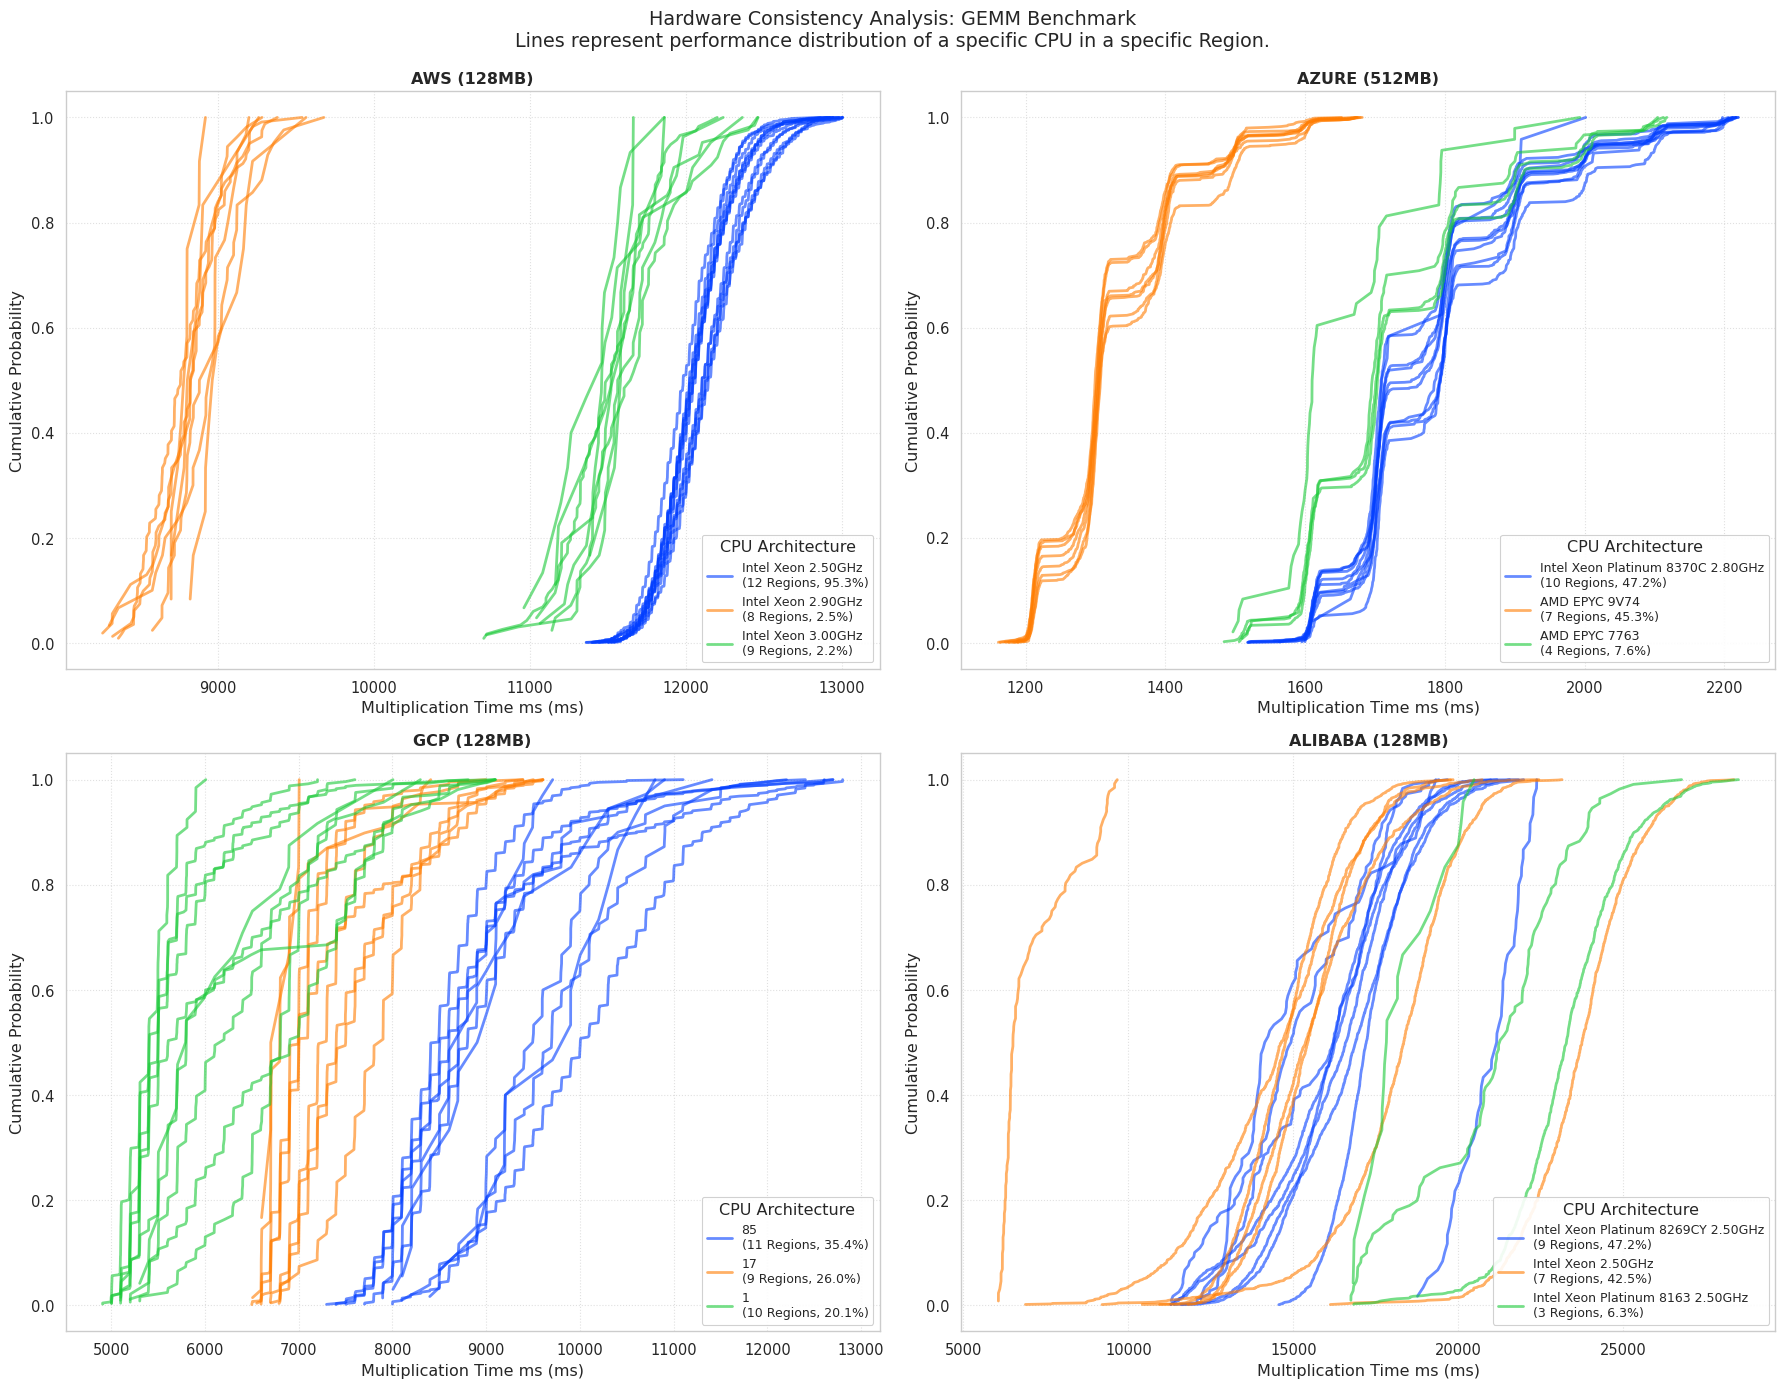

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helpers.cpus import clean_cpu_string, shorten_cpu_name


# Set a professional plotting theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
# ==============================================================================
# 3. DATA FILTERING LOGIC
# ==============================================================================

def filter_complete_groups(df, provider, memory_size, benchmark_type="gemm"):
    """
    Optimized filtering:
    1. Filter by metadata
    2. Clean CPU names (MERGES DUPLICATES)
    3. Keep only complete groups (4 invs)
    4. Remove outliers (Tukey)
    """
    
    # 1. Basic Metadata Filter
    mask = (
        (df["provider"] == provider) &
        (df["memory_size_mb"] == memory_size) &
        (df["benchmark_type"] == benchmark_type)
    )
    df_filtered = df[mask].copy()
    
    if df_filtered.empty:
        return df_filtered

    # 2. Normalize CPU Names immediately
    df_filtered["cpu_type"] = df_filtered["cpu_type"].apply(clean_cpu_string)
    
    # 3. Complete Groups Filter
    inv_counts = df_filtered["instance_id"].value_counts()
    valid_ids = inv_counts[inv_counts == 4].index
    df_filtered = df_filtered[df_filtered["instance_id"].isin(valid_ids)]
    
    # 4. Outlier Detection (Tukey Method per CPU Type)
    metric = "multiplication_time_ms"
    
    def is_outlier(x):
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        return (x < lower) | (x > upper)

    if metric in df_filtered.columns:
        outlier_mask = df_filtered.groupby("cpu_type")[metric].transform(is_outlier)
        bad_instances = df_filtered.loc[outlier_mask, "instance_id"].unique()
        df_filtered = df_filtered[~df_filtered["instance_id"].isin(bad_instances)]

    # 5. Filter for Warm Starts (Inv > 1)
    df_filtered = df_filtered[df_filtered["invocation_count"] > 1]
    
    return df_filtered.copy()

def select_top_cpus(df_filtered, top_n=3, min_samples=10):
    if df_filtered.empty: return []
    
    cpu_stats = df_filtered.groupby("cpu_type").agg({"instance_id": "count"})
    cpu_stats = cpu_stats[cpu_stats["instance_id"] >= min_samples]
    selected_cpus = cpu_stats.sort_values("instance_id", ascending=False).head(top_n).index.tolist()
    
    return selected_cpus

# ==============================================================================
# 4. VISUALIZATION & ANALYSIS
# ==============================================================================

def plot_cpu_consistency_simplified(df, providers=None, memory_configs=None,
                                   benchmark_type="gemm", top_n=3, min_samples=20):
    """
    Generates ECDF plots showing CPU consistency across regions.
    """
    
    if providers is None: providers = ["aws", "azure", "gcp", "alibaba"]
    if memory_configs is None: memory_configs = {p: 512 for p in providers}
    if "timestamp" in df.columns: df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    
    metric = "multiplication_time_ms" if benchmark_type == "gemm" else "runtime_ms"
    metric_label = metric.replace('_', ' ').title().replace("Ms", "ms")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        memory_size = memory_configs.get(provider, 512)
        
        # 1. Filter Data
        df_prov = filter_complete_groups(df, provider, memory_size, benchmark_type)
        
        if df_prov.empty:
            ax.text(0.5, 0.5, f"No Data: {provider.upper()}", ha='center', transform=ax.transAxes)
            ax.axis('off')
            continue
            
        # 2. Select Top CPUs
        top_cpus = select_top_cpus(df_prov, top_n=top_n, min_samples=min_samples)
        
        if not top_cpus:
            ax.text(0.5, 0.5, "Insufficient CPU Samples", ha='center', transform=ax.transAxes)
            continue
            
        palette = sns.color_palette("bright", len(top_cpus))
        lines_for_legend = []
        labels_for_legend = []
        total_invocations = len(df_prov)
        
        for cpu_i, cpu_name in enumerate(top_cpus):
            cpu_data = df_prov[df_prov["cpu_type"] == cpu_name]
            regions = sorted(cpu_data["region"].unique())
            
            share = (len(cpu_data) / total_invocations) * 100
            cpu_clean = shorten_cpu_name(cpu_name, 40)
            color = palette[cpu_i]
            
            # --- LEGEND FIX: Track if we've added this CPU to legend yet ---
            added_to_legend = False
            
            for r_i, region in enumerate(regions):
                r_data = cpu_data[cpu_data["region"] == region][metric].sort_values()
                if len(r_data) < 5: continue
                
                y_vals = np.arange(1, len(r_data) + 1) / len(r_data)
                
                line, = ax.plot(r_data, y_vals, color=color, alpha=0.6, linewidth=2)
                
                # --- FIX: Add to legend the FIRST time we successfully plot, not just on r_i==0 ---
                if not added_to_legend:
                    lines_for_legend.append(line)
                    labels_for_legend.append(f"{cpu_clean}\n({len(regions)} Regions, {share:.1f}%)")
                    added_to_legend = True

        ax.legend(lines_for_legend, labels_for_legend, title="CPU Architecture", 
                 fontsize=9, loc="lower right", framealpha=0.9)
        
        ax.set_title(f"{provider.upper()} ({memory_size}MB)", fontweight='bold')
        ax.set_xlabel(f"{metric_label} (ms)")
        ax.set_ylabel("Cumulative Probability")
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.suptitle(f"Hardware Consistency Analysis: {benchmark_type.upper()} Benchmark\n"
                 "Lines represent performance distribution of a specific CPU in a specific Region.", y=0.99)
    plt.tight_layout()
    OUT_DIR = "../holy/plots/StageA"
    plt.savefig(f"{OUT_DIR}/cpu_consistency_all_lowest_{benchmark_type}.pdf", bbox_inches='tight')
    plt.show()

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

mixed_memory_config = {
    "aws": 128,
    "gcp": 128,
    "alibaba": 128,
    "azure": 512
}

plot_cpu_consistency_simplified(
    df, 
    providers=["aws", "azure", "gcp", "alibaba"],
    memory_configs=mixed_memory_config,
    benchmark_type="gemm",
    top_n=3,
    min_samples=20
)